# Library Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Dataset Generation

In [16]:
def generate_dataset(N=1000, features=3, classes=5):
    dataset = []

    for c in range(classes):
        samples = np.random.randn(N//classes, features) + np.random.randn(features)
        label = np.full((N//classes, 1), c)
        dataset.append(np.concatenate([samples, label], axis=1))

    dataset = np.concatenate(dataset, axis=0)
    np.random.shuffle(dataset)
    return dataset

In [84]:
def generate_spiral(n_points=2000, classes=5):
    X = []
    y = []
    for class_id in range(classes):
        ix = range(n_points//classes)
        r = np.linspace(0.0, 1, n_points//classes)     # radius
        t = np.linspace(class_id*4, class_id*4 + 4, n_points//classes) + np.random.randn(n_points//classes)*0.2
        x1 = r * np.sin(t)
        x2 = r * np.cos(t)
        x3 = r * np.sin(t*0.5) # extra feature adds complexity
        X.append(np.c_[x1, x2, x3])
        y.append(np.full(n_points//classes, class_id))
    return np.vstack(X), np.hstack(y)


In [18]:
# dataset = generate_dataset(N=1000, features=3, classes=5)

In [78]:
dataset = generate_spiral()

In [82]:
dataset[0].shape

(2000, 3)

In [83]:
dataset[1].shape

(2000,)

In [86]:
# generate data
X, y = generate_spiral(n_points=2000, classes=5)

# shuffle
idx = np.random.permutation(X.shape[0])
X = X[idx]
y = y[idx]

In [89]:
X[:50], y[:50]

(array([[-0.2635515 ,  0.24655841,  0.14364358],
        [ 0.03984674, -0.27532702, -0.27747744],
        [-0.19156066,  0.46049208,  0.09767153],
        [-0.1328545 , -0.45467176, -0.46890701],
        [-0.01784839, -0.03020899,  0.03384607],
        [-0.23191795, -0.37521421, -0.42431101],
        [-0.76750028,  0.13595393, -0.50078491],
        [ 0.87198058,  0.35066677, -0.52618594],
        [ 0.0092977 ,  0.04157966,  0.00467711],
        [ 0.25334538, -0.63017937,  0.66683074],
        [-0.02718043, -0.03909984,  0.04543936],
        [-0.00607011,  0.01096303, -0.00313472],
        [-0.5854638 , -0.21606298, -0.51199969],
        [-0.16062978, -0.48274937, -0.50222415],
        [ 0.60287439, -0.58074669,  0.77034508],
        [ 0.94363138,  0.31553112, -0.58139941],
        [ 0.09012016,  0.09414444,  0.04855599],
        [-0.12620829,  0.4121886 ,  0.063807  ],
        [ 0.30541127,  0.27131829,  0.16740722],
        [-0.77969961,  0.2758794 , -0.47742539],
        [-0.68909131

In [90]:
X_train, y_train = X[:800], y[:800].astype(int)
X_test, y_test = X[800:], y[800:].astype(int)

In [91]:
def one_hot(y_true):
    one_hot_y = np.zeros((y_true.shape[0], 5))
    one_hot_y[np.arange(y_true.shape[0]), y_true] = 1
    return one_hot_y

In [92]:
y_train_one_hot = one_hot(y_train)
y_test_one_hot = one_hot(y_test)

In [93]:
y_train_one_hot[:5]

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [94]:
y_test_one_hot[:5]

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [95]:
def cross_entropy(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))


In [ ]:
class NeuralNetwork(object):
    def __init__(self):
        # neuron size per layer
        self.inputLayerNeurons = 3
        self.hiddenLayer1Neurons = 8
        self.hiddenLayer2Neurons = 6
        self.hiddenLayer3Neurons = 4
        self.outputLayerNeurons = 5

        self.learning_rate = 0.01
        self.error = []
        self.val_error = []

        # weights (He initialization)
        self.W1 = np.random.randn(self.inputLayerNeurons, self.hiddenLayer1Neurons) * np.sqrt(2/self.inputLayerNeurons)
        self.W2 = np.random.randn(self.hiddenLayer1Neurons, self.hiddenLayer2Neurons) * np.sqrt(2/self.hiddenLayer1Neurons)
        self.W3 = np.random.randn(self.hiddenLayer2Neurons, self.hiddenLayer3Neurons) * np.sqrt(2/self.hiddenLayer2Neurons)
        self.W4 = np.random.randn(self.hiddenLayer3Neurons, self.outputLayerNeurons) * np.sqrt(2/self.hiddenLayer3Neurons)

        # biases (zeros)
        self.b1 = np.zeros((self.hiddenLayer1Neurons,))
        self.b2 = np.zeros((self.hiddenLayer2Neurons,))
        self.b3 = np.zeros((self.hiddenLayer3Neurons,))
        self.b4 = np.zeros((self.outputLayerNeurons,))

    def relu(self, x, der=False):
        if der:
            return (x > 0).astype(float)
        return np.maximum(0, x)

    def softmax(self, z):
      z = z - np.max(z, axis=1, keepdims=True)
      e_z = np.exp(z)
      return e_z / np.sum(e_z, axis=1, keepdims=True)


    def feedForward(self, X):
        # X: (N,3)
        self.z1 = np.dot(X, self.W1) + self.b1      # (N,10)
        self.h1 = self.relu(self.z1)

        self.z2 = np.dot(self.h1, self.W2) + self.b2  # (N,10)
        self.h2 = self.relu(self.z2)

        self.z3 = np.dot(self.h2, self.W3) + self.b3  # (N,10)
        self.h3 = self.relu(self.z3)

        self.z4 = np.dot(self.h3, self.W4) + self.b4  # (N,5)
        self.ouput = self.softmax(self.z4)            # (N,5)

        return self.ouput

    def backPropagation(self, X, y_true):
        m = X.shape[0]

        # output layer
        dz4 = self.ouput - y_true                    # (N,5)
        dW4 = np.dot(self.h3.T, dz4) / m             # (10,5)
        db4 = np.sum(dz4, axis=0) / m                # (5,)

        # hidden layers
        # chain rule: dz = dh * relu'(z)
        # where dh = dz * W^T
        # and relu'(z) = 1 if z > 0 else 0
        dh3 = np.dot(dz4, self.W4.T)                 # (N,10)
        dz3 = dh3 * self.relu(self.z3, der=True)     # (N,10)
        dW3 = np.dot(self.h2.T, dz3) / m             # (10,10)
        db3 = np.sum(dz3, axis=0) / m

        dh2 = np.dot(dz3, self.W3.T)                 # (N,10)
        dz2 = dh2 * self.relu(self.z2, der=True)
        dW2 = np.dot(self.h1.T, dz2) / m             # (10,10)
        db2 = np.sum(dz2, axis=0) / m

        dh1 = np.dot(dz2, self.W2.T)                 # (N,10)
        dz1 = dh1 * self.relu(self.z1, der=True)
        dW1 = np.dot(X.T, dz1) / m                   # (3,10)
        db1 = np.sum(dz1, axis=0) / m

        # gradient descent step
        self.W4 -= self.learning_rate * dW4
        self.b4 -= self.learning_rate * db4

        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3

        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def train(self, X, y):
        output = self.feedForward(X)
        loss = cross_entropy(y, output)
        self.error.append(loss)
        self.backPropagation(X, y)
        return loss

    def evaluate(self, X, y_true_one_hot):
      y_pred = self.feedForward(X)
      pred_classes = np.argmax(y_pred, axis=1)
      true_classes = np.argmax(y_true_one_hot, axis=1)
      accuracy = np.mean(pred_classes == true_classes)

      # confusion matrix
      num_classes = y_true_one_hot.shape[1]
      cm = np.zeros((num_classes, num_classes), dtype=int)
      for t, p in zip(true_classes, pred_classes):
          cm[t, p] += 1

      return {
          "accuracy": accuracy,
          "confusion_matrix": cm,
          "predicted_classes": pred_classes,
          "true_classes": true_classes,
          "probabilities": y_pred
      }

    def predict(self, X):
      pred = self.feedForward(X)
      return np.argmax(pred, axis=1)

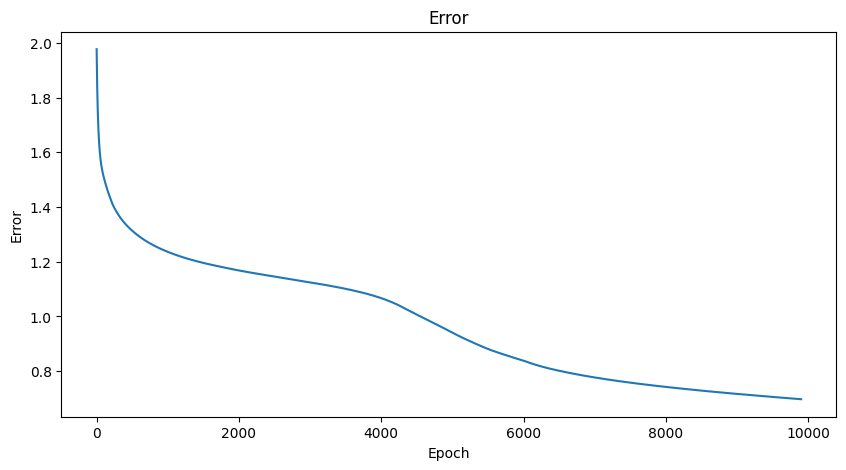

Epoch:  9900 Loss:  0.6971312923407854


In [106]:
from IPython import display

NN = NeuralNetwork()
for i in range(10000):
    NN.train(X_train, y_train_one_hot)
    loss = NN.error
    display.clear_output(wait=True)
    if i % 100 == 0:
      plt.figure(figsize=(10, 5))
      plt.plot(loss)
      plt.title("Error")
      plt.xlabel("Epoch")
      plt.ylabel("Error")
      plt.show()
      print("Epoch: ", i, "Loss: ", loss[-1])

In [107]:
NN.evaluate(X_test, y_test_one_hot)

{'accuracy': np.float64(0.625),
 'confusion_matrix': array([[200,  12,   0,  20,   8],
        [  0, 208,   0,   0,  32],
        [  0,   7, 227,   0,   0],
        [191,  28,   0,  17,   0],
        [  0, 151,   0,   1,  98]]),
 'predicted_classes': array([0, 0, 0, ..., 4, 1, 0]),
 'true_classes': array([3, 0, 0, ..., 0, 4, 0]),
 'probabilities': array([[0.47342425, 0.02697155, 0.00368073, 0.45592928, 0.0399942 ],
        [0.47342425, 0.02697155, 0.00368073, 0.45592928, 0.0399942 ],
        [0.47342425, 0.02697155, 0.00368073, 0.45592928, 0.0399942 ],
        ...,
        [0.1068208 , 0.33811591, 0.00183656, 0.04916969, 0.50405705],
        [0.17140468, 0.29388999, 0.05953152, 0.2278525 , 0.24732131],
        [0.47342425, 0.02697155, 0.00368073, 0.45592928, 0.0399942 ]])}

In [126]:
X.shape

(2000, 3)

In [149]:
y[:10]

array([1, 2, 1, 2, 4, 2, 2, 1, 0, 0])

In [151]:
print(NN.predict(np.array(X[:10])))

[1 2 4 2 1 2 2 1 1 0]
